In [35]:

import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap



In [22]:
# Enable the cache
#ff1.Cache.enable_cache('../cache')

# Setup plotting
plotting.setup_mpl()

# Load the session 
session = ff1.get_session(2021, 'Abu Dhabi', 'Q')

# Load the laps and telemetry
session.load(laps=True, telemetry=True)

# Get the laps from the drivers we want to compare
laps_ver = session.laps.pick_driver('VER')
laps_ham = session.laps.pick_driver('HAM')

# Get the telemetry data from their fastest lap
fastest_ver = laps_ver.pick_fastest().get_telemetry().add_distance() 
fastest_ham = laps_ham.pick_fastest().get_telemetry().add_distance()

# Add driver labels
fastest_ver['Driver'] = 'VER'
fastest_ham['Driver'] = 'HAM'

# Merge both lap telemetry DataFrames
import pandas as pd
telemetry = pd.concat([fastest_ver, fastest_ham], ignore_index=True)

# Print merged telemetry
print(telemetry)

c:\Users\Luis\anaconda3\envs\minisector\Lib\site-packages\fastf1\plotting\_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(
c:\Users\Luis\anaconda3\envs\minisector\Lib\site-packages\fastf1\plotting\_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(
logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
req            INFO 	Data has been written to cache!
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.4.0]
req            INFO 	Using cache

                        Date            SessionTime DriverAhead  \
0    2021-12-11 13:52:51.006 0 days 01:07:50.822000               
1    2021-12-11 13:52:51.029 0 days 01:07:50.845000               
2    2021-12-11 13:52:51.036 0 days 01:07:50.852000               
3    2021-12-11 13:52:51.249 0 days 01:07:51.065000               
4    2021-12-11 13:52:51.276 0 days 01:07:51.092000          11   
...                      ...                    ...         ...   
1434 2021-12-11 14:02:39.238 0 days 01:17:39.054000          16   
1435 2021-12-11 14:02:39.329 0 days 01:17:39.145000          16   
1436 2021-12-11 14:02:39.478 0 days 01:17:39.294000          16   
1437 2021-12-11 14:02:39.549 0 days 01:17:39.365000          16   
1438 2021-12-11 14:02:39.716 0 days 01:17:39.532000          16   

      DistanceToDriverAhead                   Time    RPM  Speed  nGear  \
0                366.041667        0 days 00:00:00  11049    234      5   
1                366.041667 0 days 00:00:00.0

Creating minisectors
Since we’re comparing the speeds across minisectors, we first need to define the minisectors. We do this by cutting the total length of the track into 25 (this number can be changed) equally-sized chunks, which will form the minisectors.

In [23]:
#Wwe want 25 mini sector (this can be adjusted up and down)

num_minisector = 25

#Grab the maximu value of distance that is known in the telemetry 

total_distance = total_distance = max(telemetry['Distance']) #This calcluates the total distance of the lap

minisector_length = total_distance / num_minisector #This calculates the length of each minisector

Now we know length of each minisector, we want to create a list that contains all the distances at which the next minisector starts.

In [24]:
#Initiate minisector variable, with 0 meters as a starting point 
minisectors = [0] 

#Add multiples of the minisector length to the minisector list

for x in range (0, (num_minisector - 1)):
    minisectors.append(minisector_length * (x + 1))

And finally, we want to assign every row that exists in the dataset a minisector. In other words, in which minisector was the car at the moment the datapoint was recorded? Do  that, we create a column Minisector in the telemetry DataFrame, which looks the Distance up in the minisectors variable we just created, to identify in which minisector we are. 

In [25]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) +1 )
    )
)

In [26]:
# Calculate avg. speed per driver per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

Then, we select the driver with the highest average speed by using idmax() , which returns the index of the row with the highest value, and then we select only the columns we need.

In [27]:
#Select the driever with highest average speed 
fastest_driver = average_speed.loc[average_speed.groupby('Minisector')['Speed'].idxmax()]

#Ger rid of the speed column and rename the driver column 

fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})


The only remaining thing we need to do is to join the fastest driver per minisector with the full telemetry data, so that we can easily plot all the data later. In addition, we need to make sure that the Distance is properly sorted. Last, but not least, we need to convert the driver abbreviation (e.g. “HAM”) to an integer value, since otherwise matplotlib won’t be able to deal with it.

In [28]:
#JOin the fastest driver per minisector with full telemtry 

telemetry = telemetry.merge(fastest_driver, on='Minisector')

#Order the data by distance to make matplotlib not consfused

telemetry = telemetry.sort_values(by=['Distance'])

#Convert driver name to integer 
telemetry.loc[telemetry['Fastest_driver'] == 'VER', 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == 'HAM', 'Fastest_driver_int'] = 2



Step 3: Plotting the data

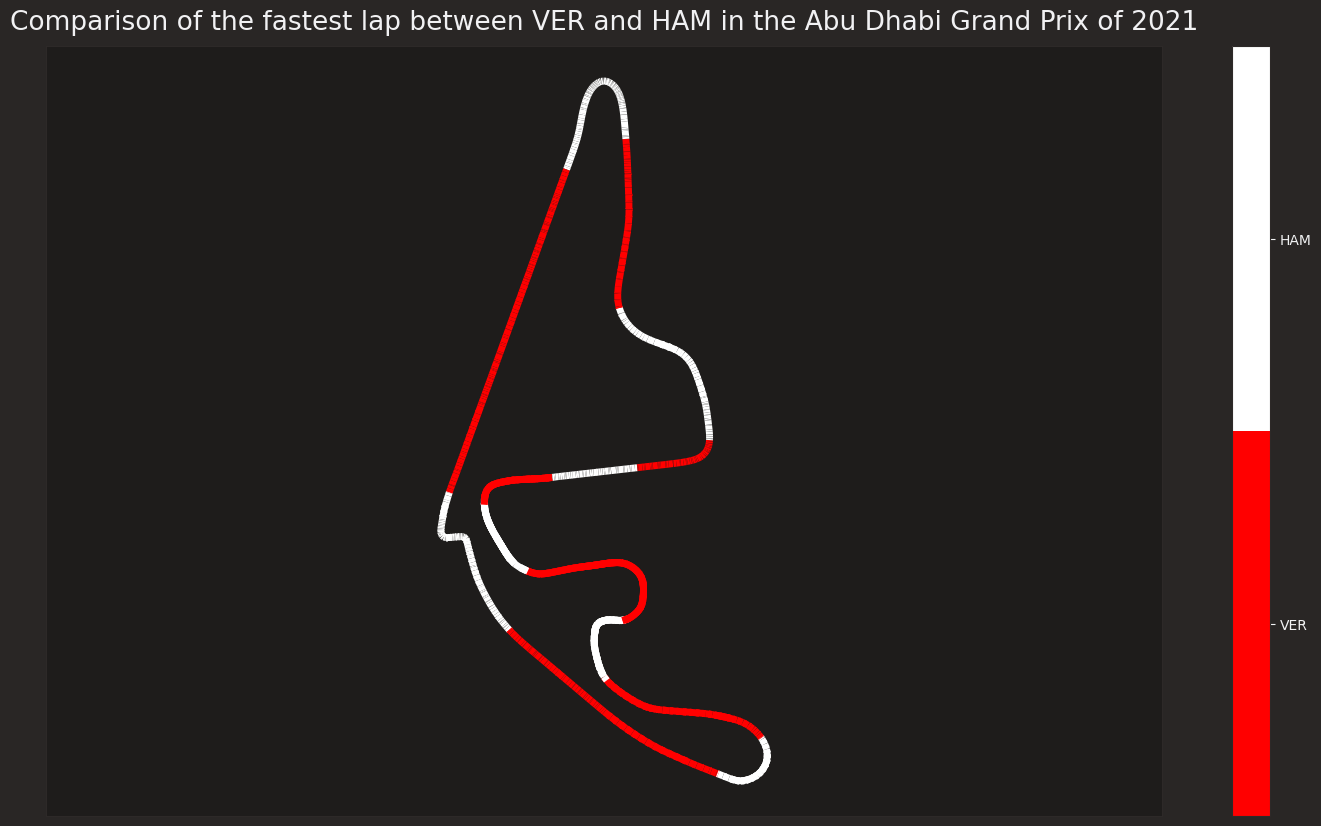

                        Date            SessionTime DriverAhead  \
0    2021-12-11 13:52:51.006 0 days 01:07:50.822000               
719  2021-12-11 14:01:17.236 0 days 01:16:17.052000               
1    2021-12-11 13:52:51.029 0 days 01:07:50.845000               
2    2021-12-11 13:52:51.036 0 days 01:07:50.852000               
720  2021-12-11 14:01:17.309 0 days 01:16:17.125000               
...                      ...                    ...         ...   
717  2021-12-11 13:54:13.049 0 days 01:09:12.865000          31   
718  2021-12-11 13:54:13.115 0 days 01:09:12.931000          31   
1436 2021-12-11 14:02:39.478 0 days 01:17:39.294000          16   
1437 2021-12-11 14:02:39.549 0 days 01:17:39.365000          16   
1438 2021-12-11 14:02:39.716 0 days 01:17:39.532000          16   

      DistanceToDriverAhead                   Time    RPM  Speed  nGear  \
0                366.041667        0 days 00:00:00  11049    234      5   
719             3313.952500        0 days 00:

In [54]:
# Generate 'x' and 'y' coordinates from telemetry data
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

# Create segments for the line collection
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create an array representing the fastest driver
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

# Ensure the values are 1 and 2
fastest_driver_array[~np.isin(fastest_driver_array, [1, 2])] = np.nan

# Define a custom colormap
cmap = ListedColormap(['red', 'white'])  # Red for VER, white for HAM

# Create the line collection
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

# Graph settings
plt.rcParams['figure.figsize'] = [18, 10]
plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title(f'Comparison of the fastest lap between {telemetry["Driver"].iloc[0]} and {telemetry["Driver"].iloc[1]} in the {session.event["EventName"]} of {session.event["EventDate"].year}')
# Create the color bar
cbar = plt.colorbar(mappable=lc_comp, boundaries=[1, 2, 3])
cbar.set_ticks([1.5, 2.5])  # Only two ticks corresponding to the drivers
cbar.set_ticklabels(['VER', 'HAM'])  # Labels for the two ticks

# Save and show the graph
plt.savefig(f"2021_ver_ham_q.png", dpi=300)
plt.show()
